# **Module 5.4: Model Evaluation & Selection**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Import everything we'll need from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification # To create imbalanced data
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score,
    classification_report,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("Setup Complete.")

Setup Complete.


## Topic 1: Regression Metrics (Recap & Deep Dive)

Let's briefly formalize the regression metrics we used in Module 5.2.

### 📏 Mean Absolute Error (MAE)
- **Formula**: (1/n) * Σ|y_true - y_pred|
- **Meaning**: The average absolute difference between predicted and actual values.
- **Interpretation**: Easy to interpret, as it's in the same units as the target.

### 🔺 Mean Squared Error (MSE)
- **Formula**: (1/n) * Σ(y_true - y_pred)²
- **Meaning**: The average of squared errors between predicted and actual values.
- **Interpretation**: Penalizes larger errors more heavily than MAE due to squaring.

### 🔻 Root Mean Squared Error (RMSE)
- **Formula**: sqrt(MSE)
- **Meaning**: Square root of the average squared error.
- **Interpretation**: Like MSE, but in the original units of the target, making it more interpretable.

### 📈 R-squared (R²)
- **Meaning**: The proportion of variance in the target that is explained by the model.
- **Score Range**: 
  - **1** = perfect model
  - **0** = model is no better than just predicting the mean

### ⚙️ Adjusted R-squared
- **Meaning**: A modified version of R² that penalizes the score for adding features that don't improve the model.
- **Note**: Not directly available in `scikit-learn.metrics`, but it can be calculated manually.


## Topic 2: Classification Metrics (Deep Dive)

This is the core of this module.

### 🧮 A. The Confusion Matrix

The foundation for most other classification metrics. It's a table that shows the performance of a classification model by comparing predicted and actual values.

|                     | **Predicted: Yes** | **Predicted: No**  |
|---------------------|--------------------|--------------------|
| **Actual: Yes**     | ✅ **True Positive (TP)**<br>Correctly identified a churner. | ❌ **False Negative (FN)**<br>Failed to identify a customer who was about to churn.<br>Often the most costly error. |
| **Actual: No**      | ❌ **False Positive (FP)**<br>Incorrectly flagged a loyal customer as a churner. (Type I Error) | ✅ **True Negative (TN)**<br>Correctly identified a non-churner. |

---

### 🔍 Quick Definitions:

- **True Positive (TP)**: Actual = Yes, Predicted = Yes  
  → The model correctly predicts churn.

- **True Negative (TN)**: Actual = No, Predicted = No  
  → The model correctly predicts loyalty.

- **False Positive (FP)** *(Type I Error)*: Actual = No, Predicted = Yes  
  → A loyal customer is wrongly predicted to churn.

- **False Negative (FN)** *(Type II Error)*: Actual = Yes, Predicted = No  
  → A churner is missed by the model — often the **most costly** mistake.


--- Confusion Matrix ---
[[71 22]
 [18 89]]


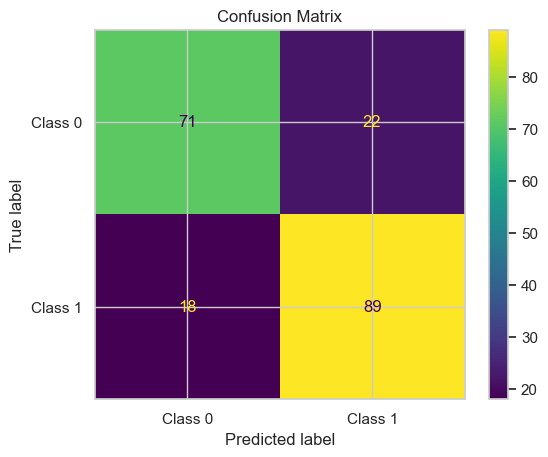

True Negatives: 71
False Positives: 22
False Negatives: 18
True Positives: 89


In [4]:
# Let's create some sample data and train a simple model
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_redundant=5, n_classes=2, random_state=42, flip_y=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- The Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("--- Confusion Matrix ---")
print(cm)

# For better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

### B. Metrics Derived from the Confusion Matrix

- **Accuracy:**  
  *(TP + TN) / (All)*  
  **What it means:** "Overall, what fraction of predictions were correct?"  
  **Pitfall:** Can be very misleading on imbalanced datasets.

- **Precision:**  
  *TP / (TP + FP)*  
  **What it means:** "Of all the times the model predicted 'Yes', what fraction were actually 'Yes'?"  
  **Insight:** High precision means a low false positive rate.

- **Recall (Sensitivity, True Positive Rate):**  
  *TP / (TP + FN)*  
  **What it means:** "Of all the actual 'Yes' cases, what fraction did the model correctly identify?"  
  **Insight:** High recall means a low false negative rate.

- **Specificity (True Negative Rate):**  
  *TN / (TN + FP)*  
  **What it means:** "Of all the actual 'No' cases, what fraction did the model correctly identify?"

- **F1-Score:**  
  *2 × (Precision × Recall) / (Precision + Recall)*  
  **What it means:** The harmonic mean of Precision and Recall.  
  **Insight:** It's a great single metric to use when you need to balance both precision and recall.


In [4]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Key Classification Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


--- Key Classification Metrics ---
Accuracy: 0.8000
Precision: 0.8018
Recall: 0.8318
F1-Score: 0.8165


### C. ROC Curve and AUC-ROC

**ROC Curve (Receiver Operating Characteristic):**  
A plot of the **True Positive Rate (Recall)** vs. the **False Positive Rate (FP / (TN + FP))** at various probability thresholds.

- A model's ability to classify is based on a probability score. The default threshold is **0.5**.
- The ROC curve shows the trade-off between **sensitivity (Recall)** and **specificity** across all possible thresholds.

**AUC (Area Under the Curve):**  
The area under the ROC curve.

#### 🎯 Interpretation ("Amaze Factor"):
- **AUC = 1.0** → Perfect model.
- **AUC = 0.5** → Useless model (equivalent to random guessing). This is the diagonal line on the ROC plot.
- **AUC < 0.5** → Model is worse than random.

AUC represents the **probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance**.

---

### D. Precision-Recall Curve

A plot of **Precision** vs. **Recall** at various probability thresholds.

#### ✅ When to use it:
This is the **preferred curve for imbalanced datasets**, because:
- It doesn't include **True Negatives** in its calculation.
- A large number of TNs can make the ROC curve **look overly optimistic** in imbalanced datasets.


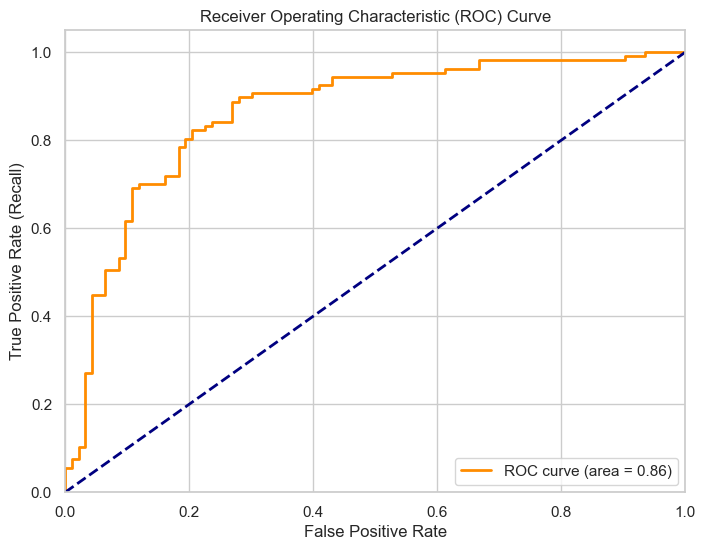

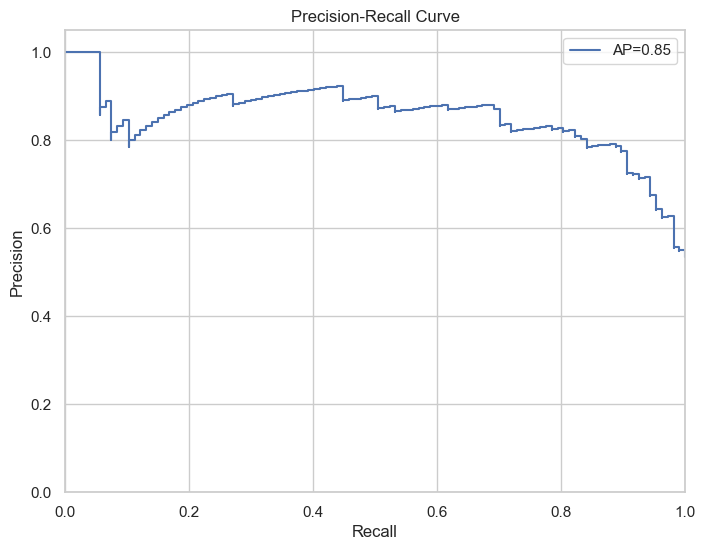

In [5]:
# To plot these curves, we need the predicted probabilities, not just the final predictions.
y_pred_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (1)

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # The "random guess" line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

### Topic 3: Dealing with Imbalanced Classes

**🛑 Problem:**  
If 99% of your data is Class A and 1% is Class B, a model can achieve **99% accuracy** by always predicting Class A.  
➡️ This is **useless** because it fails to detect the minority class.

---

### ✅ Solutions:

#### 1. Use Appropriate Metrics
- Focus on **Precision**, **Recall**, **F1-Score**, and the **Precision-Recall (PR) Curve**
- Do **not rely only on Accuracy**
---
#### 2. Resampling Techniques

- **Oversampling (e.g., SMOTE):**  
  Synthetically creates new minority class samples to balance the dataset.

- **Undersampling:**  
  Randomly removes majority class samples.  
  ⚠️ Risk: Can lead to **loss of valuable information**
---
#### 3. Cost-Sensitive Learning (Conceptual & Practical)

So far, we have discussed two ways to handle imbalanced classes:
- Using appropriate evaluation metrics (like Recall and PR Curves).
- Resampling the data (like SMOTE to oversample the minority class).

There is a **third, very powerful and often preferred method**: **Cost-Sensitive Learning**.

**The Concept:**
Instead of changing the data, we **change the algorithm** itself to pay more attention to the minority class.

- We tell the model that making a mistake on a minority class sample is **more costly** than making a mistake on a majority class sample.
- The model's internal cost function (like **Log-Loss**) is **modified**.
- During training:
  - If the model misclassifies a minority class point, it receives a **higher penalty**.
  - This forces the model to work harder to get the minority class examples right.
- This effectively **shifts the decision boundary** to favor the minority class.


**The "Amaze Factor" Advantage:**
- ✅ **No Data Synthesis**: Unlike SMOTE, you're not creating synthetic data points.
- ✅ **No Information Loss**: Unlike undersampling, you're not removing majority class data.
- ✅ **Often Simpler/Faster**: Computationally simpler than full resampling.


**Practical Implementation in Scikit-learn:**

Many `scikit-learn` classifiers have a `class_weight` hyperparameter.

- You can manually set a dictionary of weights:
  - `class_weight = {0: 1, 1: 10}` which tells the model to weight class 1 ten times more heavily than class 0.
  - Even better, you can simply set `class_weight='balanced'`. When you do this, the model automatically calculates the weights inversely proportional to the class frequencies in the input data. So, the smaller the class, the higher its weight.

**When to Use**
- When you want to focus on minimizing specific types of errors (e.g., false negatives)
- When you're working with high-stakes predictions like:
    - Fraud Detection
    - Churn Prediction
    - Medical Diagnosis

In [8]:
from imblearn.over_sampling import SMOTE
# SMOTE should only be applied to the TRAINING data to prevent data leakage.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n--- Class distribution before and after SMOTE ---")
print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_smote).value_counts())


--- Class distribution before and after SMOTE ---
Before SMOTE: 1    406
0    394
Name: count, dtype: int64
After SMOTE: 0    406
1    406
Name: count, dtype: int64


In [11]:
# 1. Create a highly imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_classes=2, random_state=42, weights=[0.95, 0.05]) # 95% class 0, 5% class 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("--- Class distribution in Training Set ---")
print(pd.Series(y_train).value_counts(normalize=True))

# 2. Train a standard Logistic Regression model
model_standard = LogisticRegression(random_state=42)
model_standard.fit(X_train, y_train)
y_pred_standard = model_standard.predict(X_test)
print("\n--- Standard Model (No Cost-Sensitivity) ---")
print(classification_report(y_test, y_pred_standard))
# Observe that Recall for class 1 will likely be very poor.

# 3. Train a Cost-Sensitive Logistic Regression model
model_balanced = LogisticRegression(random_state=42, class_weight='balanced')
model_balanced.fit(X_train, y_train)
y_pred_balanced = model_balanced.predict(X_test)
print("\n--- Cost-Sensitive Model (class_weight='balanced') ---")
print(classification_report(y_test, y_pred_balanced))
# Observe that Recall for class 1 should be significantly higher,
# likely at the cost of some precision and accuracy.

--- Class distribution in Training Set ---
0    0.9475
1    0.0525
Name: proportion, dtype: float64

--- Standard Model (No Cost-Sensitivity) ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       189
           1       1.00      0.09      0.17        11

    accuracy                           0.95       200
   macro avg       0.97      0.55      0.57       200
weighted avg       0.95      0.95      0.93       200


--- Cost-Sensitive Model (class_weight='balanced') ---
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       189
           1       0.21      0.91      0.34        11

    accuracy                           0.81       200
   macro avg       0.60      0.86      0.62       200
weighted avg       0.95      0.81      0.86       200



### Topic 4: Hyperparameter Tuning

**Hyperparameters**  
Hyperparameters are settings for a model that are **not learned from the data** but are set **prior to training**.  
Examples:
- `n_neighbors` in **KNN**
- `C` in **SVM**
- `max_depth` in a **Decision Tree**

---

**Goal**  
Find the combination of hyperparameters that results in the **best model performance**.

---

**Techniques for Hyperparameter Tuning**

1. **GridSearchCV** (Grid Search with Cross-Validation)  
   - Tries **every combination** of hyperparameters you provide.  
   - **Exhaustive** and **accurate**, but can be **computationally expensive**.

2. **RandomizedSearchCV**  
   - Samples a **fixed number** of random combinations.  
   - More **efficient** than Grid Search when the search space is large.

3. **Bayesian Optimization** *(Advanced)*  
   - Uses the results of **past trials** to intelligently decide the next combination to try.  
   - **Efficient** and **smart**, but more **complex to implement manually**.  
   - Often used via specialized libraries like `Optuna`, `Hyperopt`, or `BayesSearchCV`.

---


In [12]:
# --- GridSearchCV Example ---
# We'll tune a RandomForestClassifier

# 1. Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

# 2. Instantiate the model and the GridSearchCV object
rf = RandomForestClassifier(random_state=42)
# cv=3 means 3-fold cross-validation. n_jobs=-1 uses all CPU cores.
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='recall')

# 3. Fit it to the training data
grid_search.fit(X_train, y_train)

# 4. Check the best parameters and best score
print("\n--- GridSearchCV Results ---")
print("Best Parameters found: ", grid_search.best_params_)
print("Best Recall score on CV: ", grid_search.best_score_)

# The grid_search object is now the best model, ready for prediction
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits

--- GridSearchCV Results ---
Best Parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best Recall score on CV:  0.07142857142857142


### Randomized Search and Bayesian Optimization

While `GridSearchCV` is thorough, it can be **computationally very expensive**, especially when dealing with:
- **Many hyperparameters**
- **Continuous parameter ranges**

This challenge is known as the **"curse of dimensionality."**  
Two powerful alternatives exist to address this issue:

---

#### A. RandomizedSearchCV

**Concept**  
- Instead of exhaustively trying every combination, `RandomizedSearchCV` **samples a fixed number** (`n_iter`) of parameter combinations from the distributions you define.

**Why it's effective**  
- In most models, only a few hyperparameters significantly impact performance.
- Randomized Search:
  - **Does not waste time** on unimportant combinations.
  - **Explores the search space more broadly**.
  - Has a **higher probability** of finding a "very good" or "near-optimal" combination **faster** than Grid Search.

**When to use it**  
- Use `RandomizedSearchCV` when:
  - Your **search space is large**.
  - You have a **limited time budget** for tuning.

---


In [13]:
# In your 5.4.1_model_evaluation_and_tuning.ipynb notebook
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint # Use this to specify a distribution for random sampling

# 1. Re-use the data from our previous example
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_redundant=5, n_classes=2, random_state=42, flip_y=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- RandomizedSearchCV Example ---
# We'll tune the same RandomForestClassifier

# 1. Define the parameter DISTRIBUTION (not a grid)
# For integers, randint is good. For floats, uniform is good.
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': randint(1, 5)
}

# 2. Instantiate the model and the RandomizedSearchCV object
rf = RandomForestClassifier(random_state=42)
# n_iter=10 means it will try 10 random combinations.
# Compare this to GridSearchCV which would have tried 3 * 6 * 4 = 72 combinations.
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10,
                                   cv=3, n_jobs=-1, verbose=2, random_state=42, scoring='recall')

# 3. Fit it to the training data
random_search.fit(X_train, y_train)

# 4. Check the best parameters and best score
print("\n--- RandomizedSearchCV Results ---")
print("Best Parameters found: ", random_search.best_params_)
print("Best Recall score on CV: ", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- RandomizedSearchCV Results ---
Best Parameters found:  {'max_depth': 30, 'min_samples_leaf': 4, 'n_estimators': 180}
Best Recall score on CV:  0.8546659404502542


#### B. Bayesian Optimization (Conceptual "Amaze Factor")

**Concept**  
- This is the **most intelligent** method of hyperparameter tuning.  
- It treats the search for the best hyperparameters as a **separate learning problem**.

---

**How it works (Intuition)**

1. **Starts** by trying a few random combinations of hyperparameters.
2. **Builds a probabilistic model** (called a **"surrogate model"**) that maps the hyperparameters to the model's score.
   - This surrogate model gives a **"best guess"** of what the performance landscape looks like.
3. **Selects the next set** of hyperparameters to try:
   - Balances:
     - **Exploitation** (focus on areas that are already known to perform well)
     - **Exploration** (test unexplored areas that could offer better performance)
4. **Updates** the surrogate model after each trial and **repeats** the process.

---

**Advantages**
- Finds optimal hyperparameters in **far fewer iterations** compared to Grid Search or Random Search.
- **Avoids wasting time** on unpromising areas of the hyperparameter space.

---

**Key Libraries**
- `scikit-learn` does **not** have built-in Bayesian Optimization.
- Popular libraries include:
  - `scikit-optimize` (which provides `BayesSearchCV`)
  - `Hyperopt`
  - `Optuna`

---

**Example using `scikit-optimize` (`BayesSearchCV`)**
- The API is designed to **look very similar** to `GridSearchCV`.


In [14]:
# You must have installed scikit-optimize: pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# 1. Define the search space (similar to param_dist, but using special objects)
search_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Categorical([None, 10, 20, 30, 40, 50]),
    'min_samples_leaf': Integer(1, 5)
}

# 2. Instantiate the model and the BayesSearchCV object
rf = RandomForestClassifier(random_state=42)
# n_iter=10 will run 10 iterations of intelligent search
bayes_search = BayesSearchCV(estimator=rf, search_spaces=search_space, n_iter=10,
                             cv=3, n_jobs=-1, verbose=2, random_state=42, scoring='recall')

# 3. Fit it
bayes_search.fit(X_train, y_train)

# 4. Check the best parameters
print("\n--- BayesSearchCV Results ---")
print("Best Parameters found: ", bayes_search.best_params_)
print("Best Recall score on CV: ", bayes_search.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

--- BayesSearchCV Results ---
Best Parameters found:  OrderedDict({'max_depth': 40, 'min_samples_leaf': 3, 'n_estimators': 129})
Best Recall score on CV:  0.862037037037037


## Topic 5: Model Selection Strategies (Beyond the Highest Score)

So far, we have picked the "best" model by sorting a DataFrame by a single metric (e.g., Accuracy, R², Recall). In the real world, this is almost always too simplistic. A robust model selection process involves a trade-off between multiple competing factors.

---

### A. The Metric Trade-off (The Business Context)

As we saw in the churn project, the "best" metric is dictated by the **business problem**.

#### **Churn Prediction**
- **Goal**: Identify as many potential churners as possible to intervene.
- **Primary Metric**: Recall. The cost of a **False Negative** (missing a churner) is very high (lost revenue).
- **Secondary Metric**: Precision. The cost of a **False Positive** (flagging a happy customer) is low, but we still want to minimize it.
- **Decision**: Choose the model with the highest **Recall**, possibly with a minimum acceptable Precision.

#### **Spam Detection**
- **Goal**: Block spam without blocking important emails.
- **Primary Metric**: Precision. The cost of a **False Positive** (marking a legit email as spam) is very high.
- **Secondary Metric**: Recall.
- **Decision**: Choose the model with the highest **Precision**.

#### **Medical Diagnosis (for a serious disease)**
- **Goal**: Identify all patients who might have the disease for further testing.
- **Primary Metric**: Recall (Sensitivity). The cost of a **False Negative** is catastrophic.
- **Secondary Metric**: Specificity.
- **Decision**: Maximize **Recall**, then consider Specificity.

> **The "Amaze Factor" Takeaway**: The best model is not the one with the highest number, but the one that best solves the business problem by minimizing the cost of the most expensive errors.

---

### B. The Performance vs. Interpretability Trade-off

#### **High Interpretability / Lower Performance**
- **Models**: Linear Regression, Logistic Regression, Decision Trees.
- **Pros**: Easy to explain. Useful in regulated industries (finance, healthcare).
- **Cons**: May not capture complex, non-linear patterns.

#### **Low Interpretability / Higher Performance (Black Box Models)**
- **Models**: Gradient Boosting (XGBoost, etc.), SVM with RBF kernels, Neural Networks.
- **Pros**: Often deliver the highest accuracy.
- **Cons**: Hard to interpret. This challenge is addressed in **XAI (eXplainable AI)**.

**Decision**:
- If explanations are essential (e.g., loan approval), use interpretable models.
- If raw predictive power is the goal (e.g., Kaggle), use complex models.

---

### C. The Prediction Speed vs. Training Time Trade-off

#### **Fast Prediction / Slow Training**
- **Models**: SVM, Gradient Boosting.
- **Details**: Slow to train, fast to predict.
- **Use Case**: Good for production systems where retraining happens offline.

#### **Fast Training / Slower Prediction**
- **Model**: K-Nearest Neighbors.
- **Details**: Almost zero training time. Prediction is slow and not scalable.
- **Use Case**: NOT ideal for real-time predictions.

**Decision**:
- For real-time predictions (e.g., fraud detection): **Fast prediction** is key.
- For offline reports: **Training time** is less important.

---

### ✅ Summary: A Robust Model Selection Strategy

1. **Define Business Goal**: What are you solving? What’s the cost of mistakes?
2. **Choose Primary Metric**: Align with the business goal (e.g., Recall for churn).
3. **Shortlist Models**: Try different types (linear, tree-based, etc.).
4. **Tune Hyperparameters**: Use GridSearchCV, RandomizedSearchCV or Bayesian Optimization with the right scoring metric.
5. **Evaluate on Multiple Criteria**:
   - Primary metric (Recall, Precision, etc.)
   - Other metrics (F1, AUC, etc.)
   - Prediction speed
   - Interpretability
6. **Make Final Decision**:
   - Choose the model that offers the **best balance** for your specific use case—not just the one with the top score.


# Mini Project:
- see 5.4.2_churn_evaluation_and_tuning